Using device: cuda
6
Class Mapping: {'cancer': 0, 'normal lung tissue': 1}
Epoch [1/10], Loss: 0.7455, Accuracy: 0.5000
Epoch [2/10], Loss: 0.5966, Accuracy: 0.6667
Epoch [3/10], Loss: 0.4551, Accuracy: 0.6667
Epoch [4/10], Loss: 0.5486, Accuracy: 0.8333
Epoch [5/10], Loss: 0.2675, Accuracy: 0.8333
Epoch [6/10], Loss: 0.0672, Accuracy: 1.0000
Epoch [7/10], Loss: 0.0530, Accuracy: 1.0000
Epoch [8/10], Loss: 0.0362, Accuracy: 1.0000
Epoch [9/10], Loss: 0.0038, Accuracy: 1.0000
Epoch [10/10], Loss: 0.0010, Accuracy: 1.0000


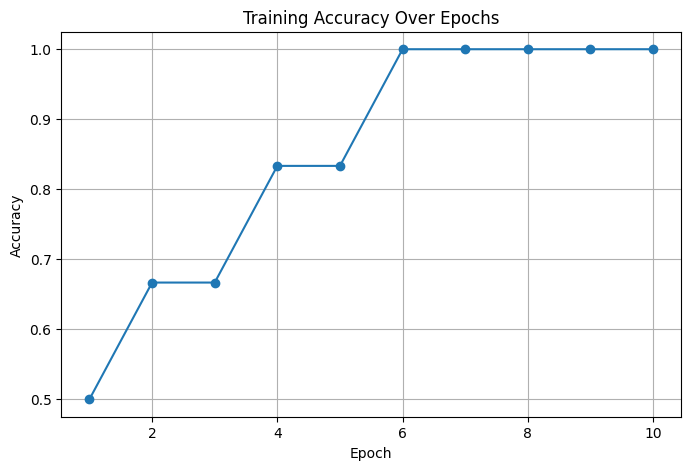

Test Loss: 0.1251, Test Accuracy: 0.9667


In [17]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Subset
from torchvision import datasets, transforms
import timm
import random

# ================================
#  Check Device
# ================================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

torch.backends.cudnn.benchmark = True

# ================================
#  Data Preprocessing & Augmentation
# ================================
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomAffine(degrees=0, shear=10),
    transforms.RandomResizedCrop(224, scale=(0.8, 1.2)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

test_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

# ================================
#  Load Datasets (Check Paths)
# ================================
train_dir = r'/content/drive/MyDrive/Data/Train'
test_dir = r'/content/drive/MyDrive/Data/Val'

if not os.path.exists(train_dir) or not os.path.exists(test_dir):
    raise FileNotFoundError("Dataset directories not found. Check the paths!")

train_dataset = datasets.ImageFolder(root=train_dir, transform=train_transform)
test_dataset = datasets.ImageFolder(root=test_dir, transform=test_transform)

# Reduce training dataset to 3% (Dataset Partioning)
num_samples = int(0.03 * len(train_dataset))
indices = random.sample(range(len(train_dataset)), num_samples)
train_subset = Subset(train_dataset, indices)
print(num_samples)

# Data Loaders
train_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

print("Class Mapping:", train_dataset.class_to_idx)

# ================================
#  Define Pretrained ViT Model for Binary Classification
# ================================
class ViTCancerClassifier(nn.Module):
    def __init__(self):
        super(ViTCancerClassifier, self).__init__()
        self.vit = timm.create_model('vit_base_patch16_224', pretrained=True)
        in_features = self.vit.head.in_features
        self.vit.head = nn.Sequential(
            nn.Linear(in_features, 256),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(256, 1)
        )

    def forward(self, x):
        return self.vit(x)

# Create Model
model = ViTCancerClassifier().to(device)

# Define Loss and Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# ================================
# Training Loop
# ================================
import matplotlib.pyplot as plt

def train(model, train_loader, criterion, optimizer, device, epochs=5):
    model.train()
    epoch_accuracies = []

    for epoch in range(epochs):
        total_loss = 0.0
        correct = 0
        total = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

        accuracy = correct / total
        epoch_accuracies.append(accuracy)
        print(f"Epoch [{epoch+1}/{epochs}], Loss: {total_loss/len(train_loader):.4f}, Accuracy: {accuracy:.4f}")

    # Plot accuracy per epoch
    plt.figure(figsize=(8, 5))
    plt.plot(range(1, epochs + 1), epoch_accuracies, marker='o', linestyle='-')
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.title("Training Accuracy Over Epochs")
    plt.grid(True)
    plt.show()

# ================================
# Evaluation Loop
# ================================
def evaluate(model, test_loader, criterion, device):
    model.eval()
    correct = 0
    total = 0
    total_loss = 0.0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device).float().unsqueeze(1)
            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = torch.sigmoid(outputs) > 0.5
            correct += (preds == labels).sum().item()
            total += labels.size(0)
            total_loss += loss.item()

    print(f"Test Loss: {total_loss/len(test_loader):.4f}, Test Accuracy: {correct/total:.4f}")

# ================================
#  Run Training & Evaluation
# ================================
if __name__ == '__main__':
    train(model, train_loader, criterion, optimizer, device, epochs=10)
    evaluate(model, test_loader, criterion, device)
